In [1]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
import config
from tqdm import tqdm

gen = Generator(in_channels=3)
checkpoint = torch.load("gen.pth.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/album

In [2]:
image_pth = "image_dataset/Test/_02529.jpg"
input = np.array(Image.open(image_pth))[:, :256, ...]
inter = np.array(Image.open(image_pth))[:, 256:512, ...]
target = np.array(Image.open(image_pth))[:, 512:, ...]

In [3]:
val_dataset = Image_dataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [2]:
val_dataset = Image_dataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

all = {"x": [], "z": [], "y": [], "y_fake": []}

# x, y = next(iter(val_loader))

per = 25
for idx, (x,z,y) in tqdm(enumerate(val_loader)):
    if idx == per: break
    x, z, y = x.to(config.DEVICE), z.to(config.DEVICE), y.to(config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x,z)
        y_fake = y_fake * 0.5 + 0.5
        y = y * 0.5 + 0.5
        x = x * 0.5 + 0.5
    all["x"].append(x)
    all["z"].append(z)
    all["y"].append(y)
    all["y_fake"].append(y_fake)
    

25it [00:02,  9.54it/s]


In [3]:
def convert(x):
    return np.moveaxis(np.array(x[0, :, :, :]), 0, -1)

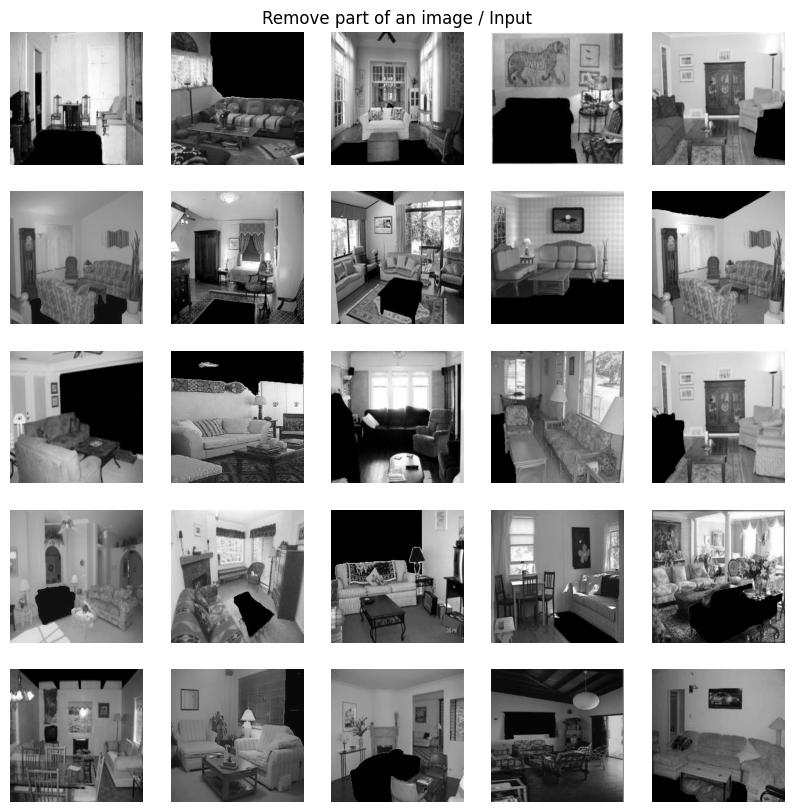

In [4]:
fig = plt.figure(figsize=(10, 10))
plt.title("Remove part of an image / Input")
plt.axis("off")
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['x'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")


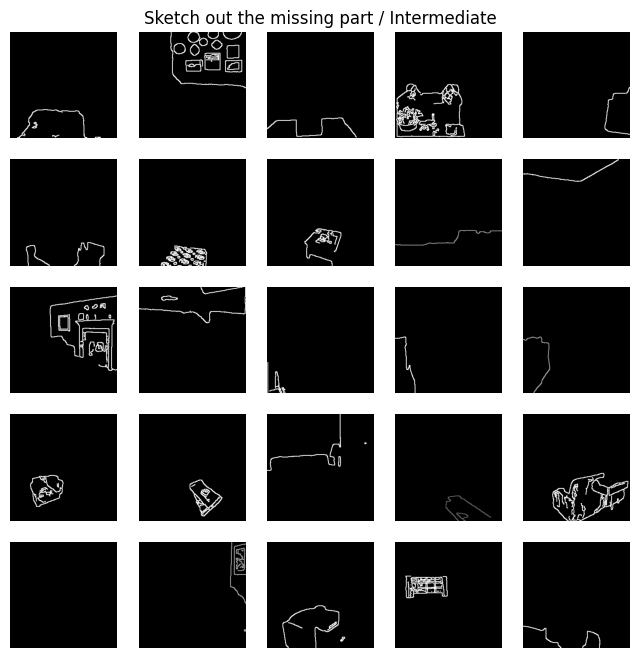

In [10]:
fig = plt.figure(figsize=(8, 8))
plt.title("Sketch out the missing part / Intermediate")
plt.axis("off")

columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['z'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


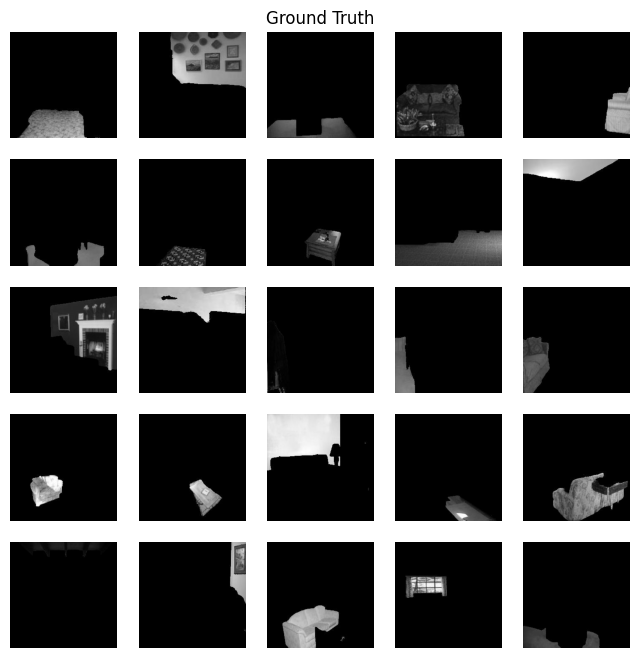

In [14]:
fig = plt.figure(figsize=(8, 8))

plt.title("Ground Truth")
plt.axis("off")


columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['y'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


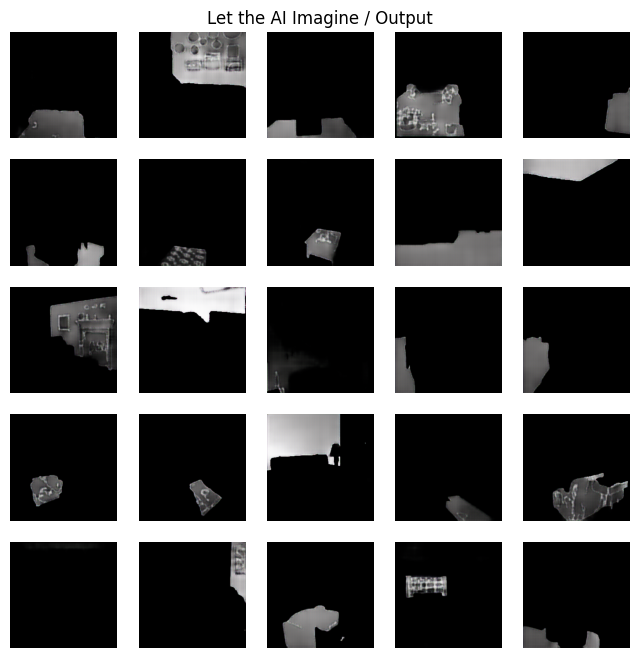

In [15]:
fig = plt.figure(figsize=(8, 8))

plt.title("Let the AI Imagine / Output")
plt.axis("off")

columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = convert(all['y_fake'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")

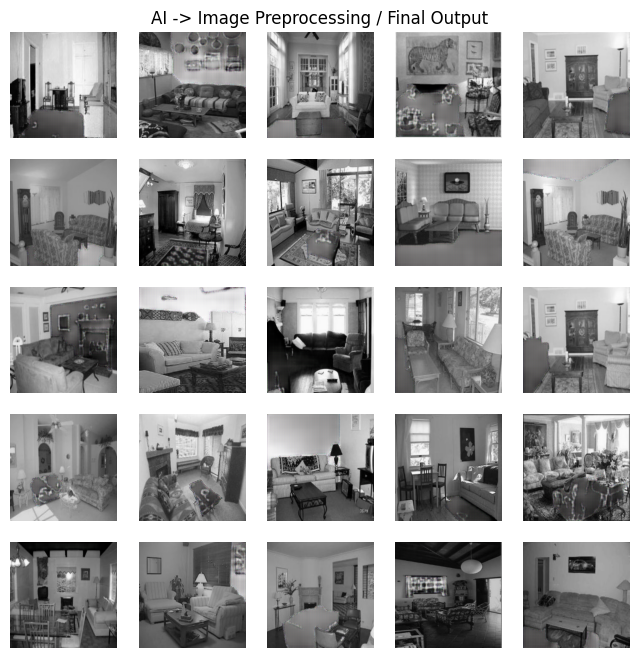

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize=(8, 8))

plt.title("AI -> Image Preprocessing / Final Output")
plt.axis("off")

columns = 5
rows = 5
threshold = 50
blend_ratio = 0.5
brightness_factor = 500
for i in range(1, columns * rows + 1):
    x_image = convert(all['x'][i - 1])
    y_fake_image = convert(all['y_fake'][i - 1])

    mask = (x_image <= threshold).all(axis=-1)

    mask_uint8 = mask.astype(np.uint8) * 255

    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel) 

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean)

    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA]) 
        largest_mask = (labels == largest_label).astype(np.uint8)  
        largest_mask = largest_mask.astype(bool)
        largest_mask = np.repeat(largest_mask[:, :, np.newaxis], 3, axis=2) 
        x_image[largest_mask] = (blend_ratio * y_fake_image[largest_mask] +
                                 (1 - blend_ratio) * x_image[largest_mask])

    else:
        print(f"No valid object found in image {i}")
    x_image = np.clip(x_image * brightness_factor, 0, 255).astype(np.uint8)

    # Plot the image in the grid
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(x_image)
    plt.axis("off") 
plt.show()